In [15]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from pathlib import Path

sys.path.append(os.path.expanduser('~/Documents/Medley'))
#from Medley.interpretation import load_pred_results

In [16]:
import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.lpcmci import LPCMCI

from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.parcorr_wls import ParCorrWLS 
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.regressionCI import RegressionCI

In [17]:
predselpath = Path('/home/jsn295/Downloads/Medley_backup/predselec/')

In [18]:
def load_pred_results(expid: str, subdir: str = None) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    predictor selection results as saved
    possible to supply old subdir
    """
    if subdir is None:
        resultspath = predselpath / f'{expid}_results.csv'
    else:
        resultspath = predselpath / subdir / f'{expid}_results.csv'
    df = pd.read_csv(resultspath, sep = ';', index_col = 0)
    df.index.name = 'npredictors'
    objecttypes = df.dtypes.loc[(df.dtypes == object).values]
    for col in objecttypes.index:
        if not col == 'cv_scores':
            f = lambda s: eval(s)
        else:
            f = lambda s: [float(f) for f in s[1:-1].split(' ') if f]
        df.loc[:,col] = df.loc[:,col].apply(f)
    cv_scores = pd.DataFrame(list(df['cv_scores'].values), index = df.index)
    cv_scores.columns.name = 'fold'
    return df.drop('cv_scores', axis = 1), cv_scores


In [54]:
deseason = True
df = pd.read_csv(f'/home/jsn295/Downloads/Medley_backup/spi1_set_season-removed-{deseason}.csv',header = [0,1,2],index_col=0)
cols = df.columns.to_frame()
cols['subindex'] = cols['subindex'].astype(int)
df.columns = pd.MultiIndex.from_frame(cols)
df.index = pd.DatetimeIndex(df.index)

In [82]:
expert = False
expid = 'dd0d579f41'
npreds = 10
target = [('SPI1',0,'ECAD')]
if expert:
    varnames = [('amoc',0,'hadisst'),('nao',0,'station'),('ao',0,'ncep'),('vortex_u20',7080,'era5'),('med_u250',40,'era5')]
else:
    preds, cv = load_pred_results(expid)
    variables = preds.loc[10,'feature_names']
    varnames = list(set([t[0] for t in variables])) # Through set to get the unique ones
    maxlag = abs(min([t[1] for t in variables]))
subset = df.loc[:,varnames + target]
subset = subset.dropna(axis = 0, how = 'any')

array([[<Axes: title={'center': "('atl_u250_latmax', 0, 'era5')"}>,
        <Axes: title={'center': "('med_u250', 60, 'era5')"}>,
        <Axes: title={'center': "('med_u500', 30, 'era5')"}>],
       [<Axes: title={'center': "('ao', 0, 'ncep')"}>,
        <Axes: title={'center': "('med_u250_latmax', 0, 'era5')"}>,
        <Axes: title={'center': "('iod', 0, 'hadisst')"}>],
       [<Axes: title={'center': "('med_u250', 30, 'era5')"}>,
        <Axes: title={'center': "('pdo', 0, 'ersstv5')"}>,
        <Axes: title={'center': "('SPI1', 0, 'ECAD')"}>]], dtype=object)

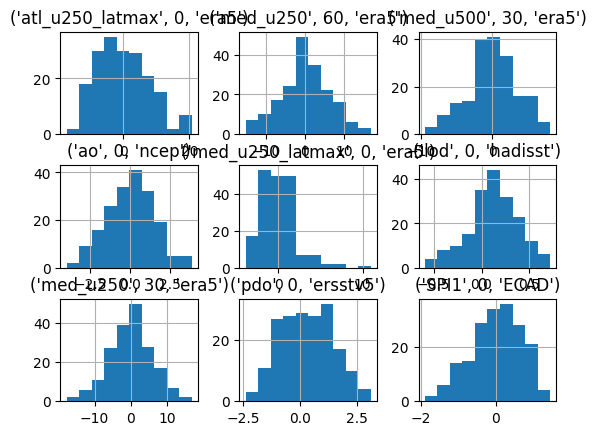

In [91]:
subset.loc[subset.index.month.isin([1,2,3]),:].hist()

In [92]:
jfmmask = np.tile(~subset.index.month.isin([1,2,3])[:,np.newaxis], (1,subset.shape[-1]))
jfmframe = pp.DataFrame(subset.values, datatime = subset.index,var_names = [f'{v[0]}_{v[1]}' for v in varnames + target], mask = jfmmask)

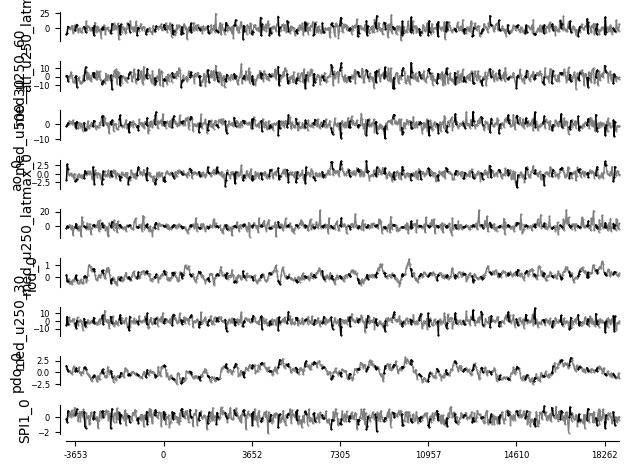

In [93]:
tp.plot_timeseries(jfmframe, grey_masked_samples='data'); plt.show()

In [103]:
tau_max = 2
tau_min = 1
pc_alpha = 0.05
alpha_level = 0.05
parcorr = ParCorr(significance='analytic',mask_type = 'y')
pcmci = PCMCI(
    dataframe=jfmframe,
    cond_ind_test=parcorr,
    verbosity=1)
results = pcmci.run_pcmci(tau_max=tau_max, tau_min = tau_min, pc_alpha=pc_alpha, alpha_level=alpha_level)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable atl_u250_latmax_0 has 0 link(s):

    Variable med_u250_60 has 1 link(s):
        (ao_0 -1): max_pval = 0.01844, |min_val| =  0.173

    Variable med_u500_30 has 2 link(s):
        (med_u250_60 -1): max_pval = 0.00083, |min_val| =  0.244
        (SPI1_0 -2): max_pval = 0.00223, |min_val| =  0.223

    Variable ao_0 has 3 link(s):
        (ao_0 -1): max_pval = 0.00047, |min_val| =  0.255
        (med_u250_60 -1): max_pval = 0.00514, |min_val| =  0.205
        (med_u250_latmax_0 -1): max_pval = 0.02336, |min_val| =  0.167

    Variable med_u250_latmax_0 has 0 link(s):

    Variable iod_0 has 2 link(s):
        (iod_0 -1): max_pval = 0.00000, |min_val| =  0.517
        (pdo_0 -1): max_pval = 0.01405, |min_val| =  0.180

    Variable med_u250_30 h

In [104]:
graph = pcmci.get_graph_from_pmatrix(p_matrix=results['p_matrix'], alpha_level=alpha_level, 
            tau_min=tau_min, tau_max=tau_max, link_assumptions=None)
results['graph'] = graph

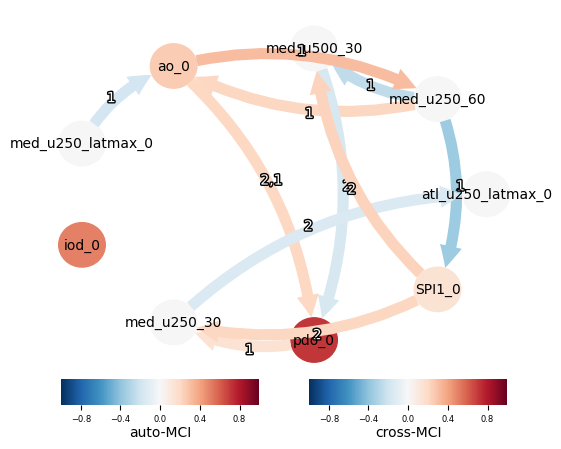

In [105]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=jfmframe.var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=False
    ); plt.show()